In [1]:
%matplotlib inline
from matplotlib.pylab import plt

import pandas as pd
import numpy as np
import statsmodels

In [2]:
import statsmodels
print(statsmodels.__version__)
print(np.__version__)
print(pd.__version__)

0.11.1
1.18.5
1.0.5


# Let's start with some informal exploration

In [3]:
air_passengers = pd.read_csv("./data/AirPassengers.csv", header = 0, parse_dates = [0], names = ['Month', 'Passengers'], index_col = 0)

In [4]:
air_passengers.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Is this the behavior I want?

In [5]:
air_passengers['1949-01-05':'1949-02-17']

,Passengers
Month,
1949-02-01,118


In [6]:
# How do we get the desired behavior?

In [7]:
air_passengers['1949-01-05':'1949-02-17']

,Passengers
Month,
1949-02-01,118


### Think about what your data means. Pandas can't do the thinking for you

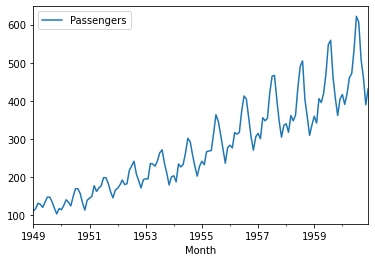

In [8]:
air_passengers.plot()

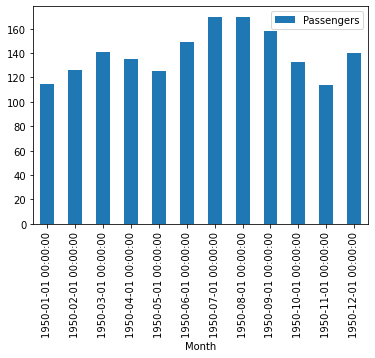

In [9]:
air_passengers['1950'].plot(kind = 'bar')

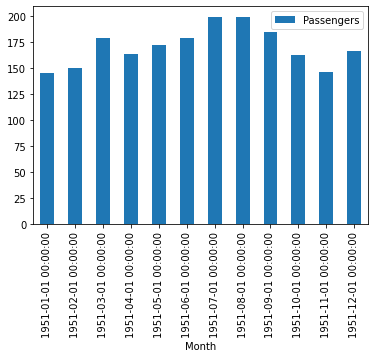

In [10]:
air_passengers['1951'].plot(kind = 'bar')

# Getting a little more formal
### first thing we look at for a time series when we want to use common analysis techniques:
### is it stationary: mean, variance, autocovariance do not depend on time

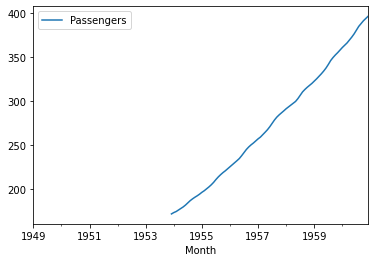

In [11]:
# first test, informally, plot the moving average
# note the ROLLING function
air_passengers.rolling(window = 60).mean().plot()

In [12]:
# How can we see whether the variance changes over time?

In [13]:
# Can you plot the autocorrelation?
from statsmodels.tsa.stattools import acf

In [14]:
# What is the autocorrelation and how can we visualize it? 

### How can I see whether the autocorrelation is changing over time?

In [15]:
# What would we do differently from above?


### Always have to make judgment calls

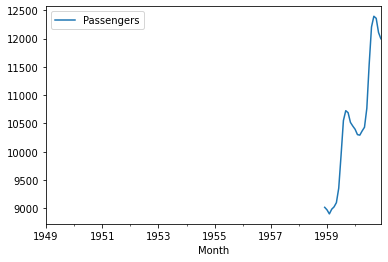

In [16]:
# How should you size your window?
air_passengers.rolling(window = 120).var().plot()

# And now let's make it formal

In [17]:
# next more formally apply the Augmented Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
adfuller(air_passengers.Passengers, autolag = 'AIC', regression = 'ct')

(-2.1007818138446694,
 0.5456589343124553,
 13,
 130,
 {'1%': -4.030152423759672,
  '5%': -3.444817634956759,
  '10%': -3.1471816659080565},
 993.2814778200581)

### What do these numbers mean? Let's take a look at statsmodels documentation

In [18]:
# Can we write a function to output these #s sensibly?
# Check out statsmodels.sourceforge.net/devel/generated/statsmodels.tsa.stattools.adfuller.html

# Where do we go from here?

In [19]:
# Are we stuck not doing any analysis now that our time series is not stationary? Hint: no.
# How can we make it stationary?
# Why is it non-stationary (2 reasons)

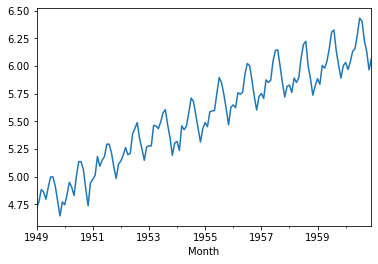

In [20]:
# One method to get rid of time varying variance is to do a power or log transformation that punishes larger values
# more than smaller values
log_passengers = air_passengers.Passengers.apply(lambda x: np.log(x))
log_passengers.plot()

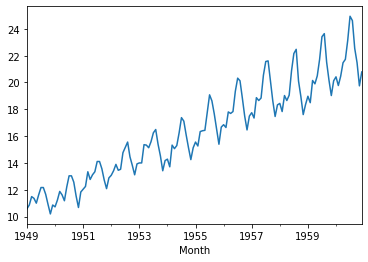

In [21]:
# Let's see what that looks like as a power transformation
rt_passengers = air_passengers.Passengers.apply(lambda x: x**.5)
rt_passengers.plot()

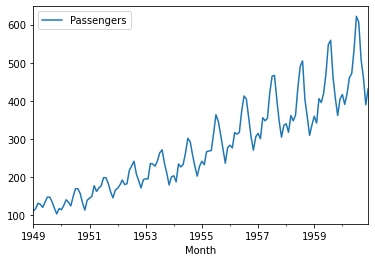

In [22]:
# This reduces the variance in variance as opposed to the original trend
air_passengers.plot()

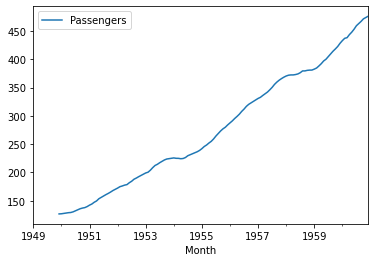

In [23]:
# However there is still a trend we need to remove
# Let's calculate a rolling mean
# Experiment with window size
air_passengers.rolling(window = 12).mean().plot()

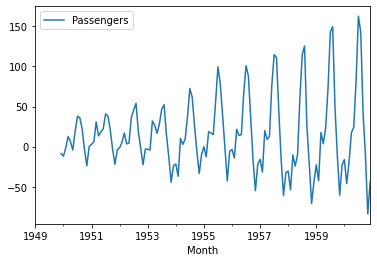

In [24]:
# What if we subtract this rolling mean from the original series?
rolling_mean = air_passengers.rolling(window = 12).mean()
passengers_detrended = air_passengers - rolling_mean
passengers_detrended.plot()

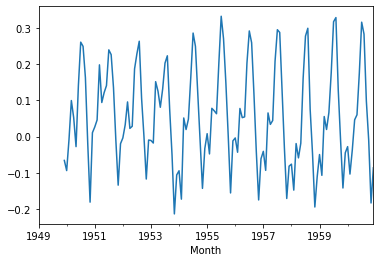

In [25]:
# Exercise: try detrending after taking the log. How does that look?
log_rolling_mean = log_passengers.rolling(window = 12).mean()
log_detrended = log_passengers - log_rolling_mean
log_detrended.plot()

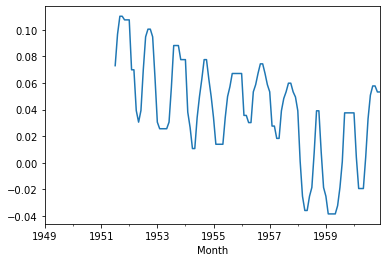

In [26]:
log_detrended.rolling(20).median().plot()

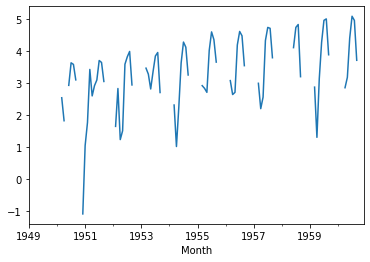

In [27]:
# Exercise: try detrending before taking the log. How does that look?
rolling_mean = air_passengers.rolling(window = 12).mean()
passengers_detrended = air_passengers - rolling_mean
log_detrended2 = passengers_detrended.Passengers.apply(lambda x: np.log(x))
log_detrended2.plot()

### Why didn't that work?

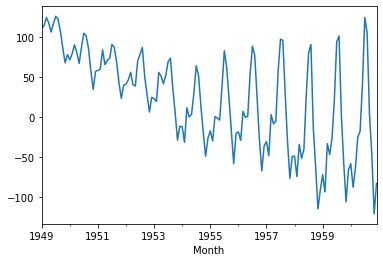

In [28]:
# Now let's use a regression rather than a rolling mean to detrend
from statsmodels.regression.linear_model import OLS
model = OLS(air_passengers.Passengers.values, list(range(len(air_passengers.values))))
result = model.fit()
result.params
fit = pd.Series(result.predict(list(range(len(air_passengers.values)))), index = air_passengers.index)

passengers_detrended = air_passengers.Passengers - fit
passengers_detrended.plot()

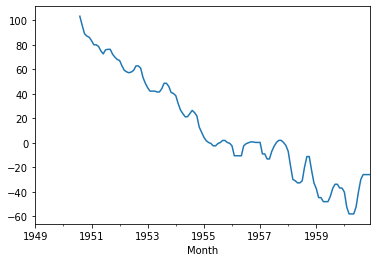

In [29]:
passengers_detrended.rolling(20).median().plot()

### What worked better, the rolling average or the regression? Why?

# Seasonality

### Differencing

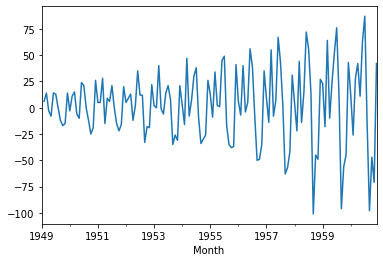

In [30]:
(air_passengers.Passengers - air_passengers.Passengers.shift()).plot()

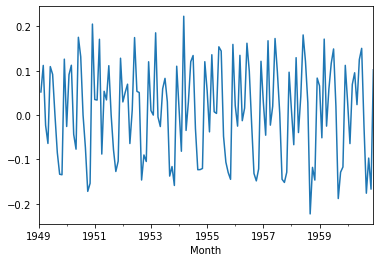

In [31]:
# One common technique is differencing, let's start with log_passengers
log_passengers_diff = log_passengers - log_passengers.shift()
log_passengers_diff.plot()

In [32]:
# Let's again test for stationarity with a gut level check.
# And let's write a function to do it since this seems like something we'll have to do a lot

In [33]:
log_passengers = log_passengers.to_timestamp()

AttributeError: 'DatetimeIndex' object has no attribute 'to_timestamp'

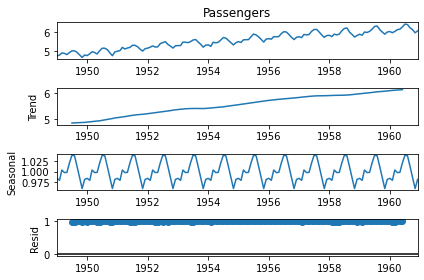

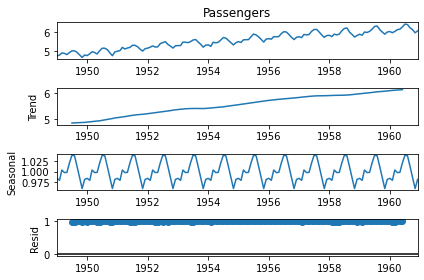

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

log_passengers.interpolate(inplace = True)
decomposition = seasonal_decompose(log_passengers, model = 'multiplicative')
decomposition.plot()

### Seasonal or multiplicative time series?

In [35]:
# When to use which?

In [36]:
decomposition = seasonal_decompose(log_passengers, model = 'multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

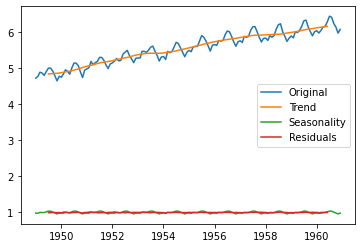

In [37]:
plt.plot(log_passengers, label='Original')
plt.plot(trend, label='Trend')
plt.plot(seasonal,label='Seasonality')
plt.plot(residual, label='Residuals')
plt.legend(loc = 'best')

# Let's walk through seasonal_decompose

In [38]:

from statsmodels.compat.python import lmap, range, iteritems
import numpy as np
from pandas.core.nanops import nanmean as pd_nanmean
from statsmodels.tsa.filters._utils import _maybe_get_pandas_wrapper_freq
from statsmodels.tsa.filters.filtertools import convolution_filter
from statsmodels.tsa.tsatools import freq_to_period

def seasonal_decompose(x, model="additive", filt=None, freq=None, two_sided=True):
    """
    Seasonal decomposition using moving averages
    Parameters
    ----------
    x : array-like
        Time series
    model : str {"additive", "multiplicative"}
        Type of seasonal component. Abbreviations are accepted.
    filt : array-like
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by two_sided.
    freq : int, optional
        Frequency of the series. Must be used if x is not  a pandas object.
        Overrides default periodicity of x if x is a pandas
        object with a timeseries index.
    two_sided : bool
        The moving average method used in filtering.
        If True (default), a centered moving average is computed using the filt.
        If False, the filter coefficients are for past values only.
    Returns
    -------
    results : obj
        A object with seasonal, trend, and resid attributes.
    Notes
    -----
    This is a naive decomposition. More sophisticated methods should
    be preferred.
    The additive model is Y[t] = T[t] + S[t] + e[t]
    The multiplicative model is Y[t] = T[t] * S[t] * e[t]
    The seasonal component is first removed by applying a convolution
    filter to the data. The average of this smoothed series for each
    period is the returned seasonal component.
    See Also
    --------
    statsmodels.tsa.filters.bk_filter.bkfilter
    statsmodels.tsa.filters.cf_filter.xffilter
    statsmodels.tsa.filters.hp_filter.hpfilter
    statsmodels.tsa.filters.convolution_filter
    """
    _pandas_wrapper, pfreq = _maybe_get_pandas_wrapper_freq(x)
    x = np.asanyarray(x).squeeze()
    nobs = len(x)

    if not np.all(np.isfinite(x)):
        raise ValueError("This function does not handle missing values")
    if model.startswith('m'):
        if np.any(x <= 0):
            raise ValueError("Multiplicative seasonality is not appropriate "
                             "for zero and negative values")

    if freq is None:
        if pfreq is not None:
            pfreq = freq_to_period(pfreq)
            freq = pfreq
        else:
            raise ValueError("You must specify a freq or x must be a "
                             "pandas object with a timeseries index with"
                             "a freq not set to None")

    if filt is None:
        if freq % 2 == 0:  # split weights at ends
            filt = np.array([.5] + [1] * (freq - 1) + [.5]) / freq
        else:
            filt = np.repeat(1./freq, freq)

    nsides = int(two_sided) + 1
    trend = convolution_filter(x, filt, nsides)

    # nan pad for conformability - convolve doesn't do it
    if model.startswith('m'):
        detrended = x / trend
    else:
        detrended = x - trend

    period_averages = seasonal_mean(detrended, freq)

    if model.startswith('m'):
        period_averages /= np.mean(period_averages)
    else:
        period_averages -= np.mean(period_averages)

    seasonal = np.tile(period_averages, nobs // freq + 1)[:nobs]

    if model.startswith('m'):
        resid = x / seasonal / trend
    else:
        resid = detrended - seasonal

    results = lmap(_pandas_wrapper, [seasonal, trend, resid, x])
    return DecomposeResult(seasonal=results[0], trend=results[1],
                           resid=results[2], observed=results[3])

ImportError: cannot import name 'range' from 'statsmodels.compat.python' (/Users/kkyuhun/opt/anaconda3/lib/python3.8/site-packages/statsmodels/compat/python.py)

In [39]:
x = log_passengers
_pandas_wrapper, pfreq = _maybe_get_pandas_wrapper_freq(x)
model = "multiplicative"

NameError: name '_maybe_get_pandas_wrapper_freq' is not defined

In [40]:
x = np.asanyarray(x).squeeze()

In [41]:
nobs = len(x)

In [42]:
nobs

144

In [43]:
if not np.all(np.isfinite(x)):
    raise ValueError("This function does not handle missing values")
if model.startswith('m'):
    if np.any(x <= 0):
        raise ValueError("Multiplicative seasonality is not appropriate "
                             "for zero and negative values")

AttributeError: 'OLS' object has no attribute 'startswith'

In [44]:
freq = None
if freq is None:
    if pfreq is not None:
        pfreq = freq_to_period(pfreq)
        freq = pfreq
    else:
        raise ValueError("You must specify a freq or x must be a "
                         "pandas object with a timeseries index with"
                         "a freq not set to None")

NameError: name 'pfreq' is not defined

In [45]:
pfreq

NameError: name 'pfreq' is not defined

In [46]:
freq

In [47]:
filt = None
two_sided = True
if filt is None:
    if freq % 2 == 0:  # split weights at ends
        filt = np.array([.5] + [1] * (freq - 1) + [.5]) / freq
    else:
        filt = np.repeat(1./freq, freq)

nsides = int(two_sided) + 1
trend = convolution_filter(x, filt, nsides)


TypeError: unsupported operand type(s) for %: 'NoneType' and 'int'

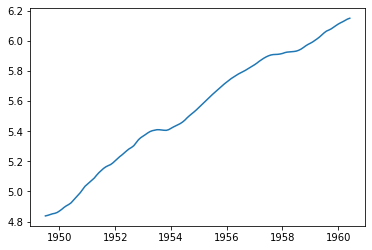

In [48]:
plt.plot(trend)

ValueError: x, y, and format string must not be None

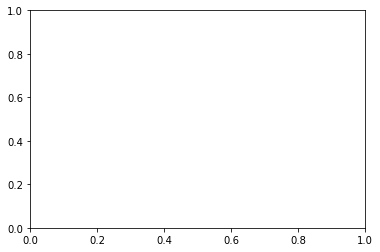

In [49]:
plt.plot(filt)

In [50]:
if model.startswith('m'):
    detrended = x / trend
else:
    detrended = x - trend

AttributeError: 'OLS' object has no attribute 'startswith'

In [51]:
plt.plot(detrended)

NameError: name 'detrended' is not defined

In [52]:
def seasonal_mean(x, freq):
    """
    Return means for each period in x. freq is an int that gives the
    number of periods per cycle. E.g., 12 for monthly. NaNs are ignored
    in the mean.
    """
    return np.array([pd_nanmean(x[i::freq]) for i in range(freq)])

In [53]:
period_averages = seasonal_mean(detrended, freq)

if model.startswith('m'):
    period_averages /= np.mean(period_averages)
else:
    period_averages -= np.mean(period_averages)

seasonal = np.tile(period_averages, nobs // freq + 1)[:nobs]

if model.startswith('m'):
    resid = x / seasonal / trend
else:
    resid = detrended - seasonal



NameError: name 'detrended' is not defined

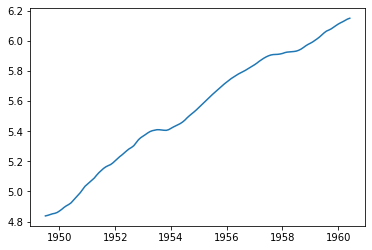

In [54]:
plt.plot(trend)